# Hospitalization cost variation sanity checks and visualizations

Date created: 2/20/23 <br>
Last updated: 2/20/23 <br>

## 0 Inputs and setup
### 0.1 Global variables
Update for your project

In [1]:
# Your local home directory
user_id = 'grolleau'

# Source data projects and datasets
nero_gcp_project = 'som-nero-phi-jonc101-secure' # *** Label rest of these
cdm_project_id = 'som-nero-phi-jonc101'
cdm_dataset_id = 'shc_core_2021'

# NERO project and dataset where you are saving your data
work_project_id = nero_gcp_project
work_dataset_id = 'proj_IP_variation'

# Cohort dataset name
cohort_id = 'cohort_drg_221'

# Hours after admission date to set index time
index_lag = 24 # NOTE: lag is from admission DATE (midnight) rather than admission TIME yet as of 1/23/23

# Thresholds
eps = 1e-6 # For 0
nz_vars = 0.05 # For uncommon features

# Control variables to run sections of code
run_cohortselection = 1 # Last run: 2/5/23
run_cohortchecks = 1
run_featurizer = 1 # Last run: 1/28/23

## Setup environment / credentials

In [2]:
from google.cloud import bigquery
import os
import pandas as pd
import sys
import yaml
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
# GCP credentials for Mac: Ran steps linked here to create JSON credentials and file path (https://github.com/HealthRex/CDSS/blob/master/scripts/DevWorkshop/ReadMe.GoogleCloud-BigQuery-VPC.txt)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = (
    f'/Users/{user_id}/.config/gcloud/application_default_credentials.json'
)
os.environ['GCLOUD_PROJECT'] = nero_gcp_project

# Use Francois' credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/grolleau/Desktop/github repos/Cost variability/grolleau_application_default_credentials.json'
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-jonc101-secure'

# Instantiate a client object so you can make queries
client = bigquery.Client()

#  Create a dataset in project to write all our tables there (if it does not exist already)
client.create_dataset(f"{work_project_id}.{work_dataset_id}", exists_ok=True)

Dataset(DatasetReference('som-nero-phi-jonc101-secure', 'proj_IP_variation'))

### 1.2 Cohort explorations and sanity checks
Record of tests and checks

In [4]:
# Download cohort data temporarily for checks
if run_cohortchecks == 1:
    query = """
        SELECT 
            *
        FROM `{work_project_id}.{work_dataset_id}.matched_drg_cost_adms`
    """.format_map({'work_project_id': work_project_id,
                    'work_dataset_id': work_dataset_id})

    df = client.query(query).to_dataframe()

In [5]:
if run_cohortchecks == 1:
    # Cohort size
    print(df.shape) # 7428, 15. 1/29/23 Update: 6232. 2/5/23 Update: 1658 (patients with costs only)
    print(df["observation_id"].nunique())
    print(type(df))
    
    # Duplicate IP admissions?
    dups = df[df.duplicated(subset=['observation_id'], keep=False)].sort_values(by=['anon_id', 'adm_date'])
    print(dups)

    # Missing values
    print(df.isna().sum())
    
    # Costs: are there non-inpatient costs that overlap with an IP visit?

    # Number of IP admissions with costs

(108702, 22)
54316
<class 'pandas.core.frame.DataFrame'>
         anon_id adm_date_jittered disch_date_jittered  discharge_year  \
41195  JC1000116        2020-09-29          2020-10-01            2020   
41196  JC1000116        2020-09-29          2020-10-01            2020   
26476  JC1000640        2019-12-31          2020-01-02            2020   
26477  JC1000640        2019-12-31          2020-01-02            2020   
31728  JC1000863        2019-12-11          2019-12-16            2020   
...          ...               ...                 ...             ...   
76577   JC999648        2021-07-25          2021-07-29            2021   
62871   JC999908        2021-03-18          2021-03-19            2021   
62872   JC999908        2021-03-18          2021-03-19            2021   
95564   JC999965        2020-01-04          2020-01-18            2019   
95565   JC999965        2020-01-04          2020-01-18            2019   

       MSDRGWeight      CPI   Cost_Adj      observatio

In [6]:
# De-duplicate
yvar = 'Hospitalization cost (relative to average)'
cost_data_filtered = df.drop_duplicates(subset=['observation_id']).copy()
cost_data_filtered[yvar] = cost_data_filtered['Cost_Adj']/np.mean(cost_data_filtered['Cost_Adj']) 


MS-DRG weight distribution

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


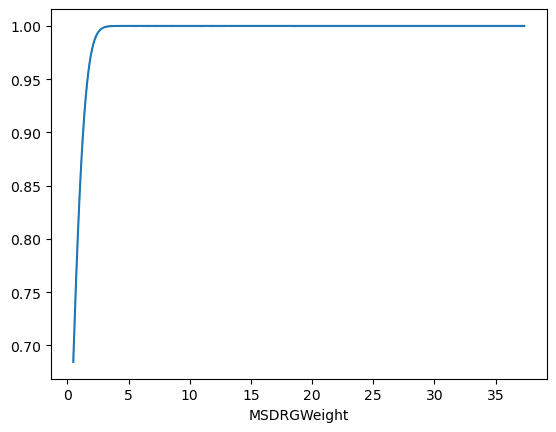

In [7]:
# Distributions of MS-DRG weights
import scipy
import seaborn as sns
x = cost_data_filtered['MSDRGWeight']
drgweight_cdf = scipy.stats.norm.cdf(x) # calculate the cdf - also discrete

# plot the cdf
sns.lineplot(x=x, y=drgweight_cdf)
plt.show()

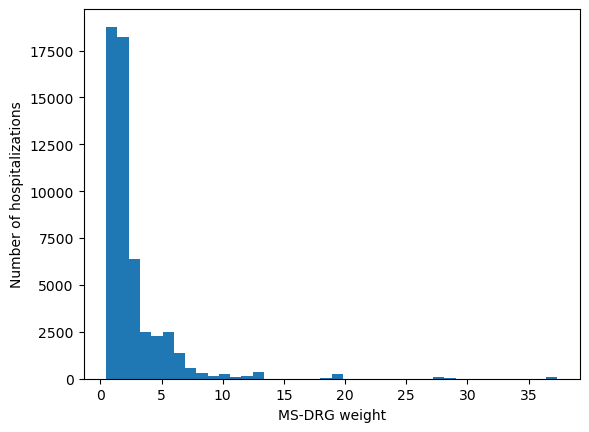

In [8]:

plt.hist(cost_data_filtered['MSDRGWeight'], bins = 40);
plt.xlabel('MS-DRG weight');
plt.ylabel('Number of hospitalizations');

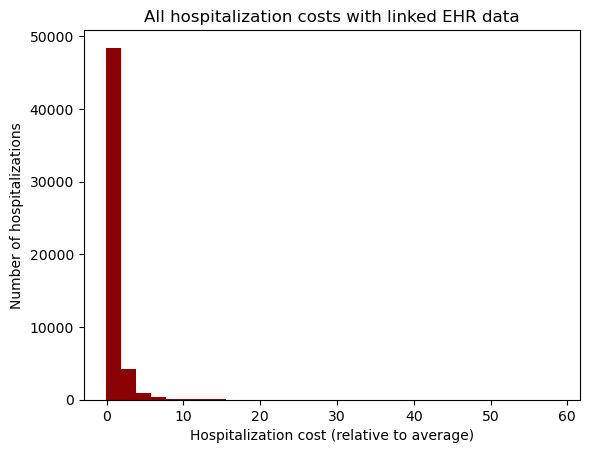

In [9]:
# Distributions of costs
def plot_cost_hist(q=1):
    qval = np.quantile(cost_data_filtered[yvar], q)
    plt.hist(cost_data_filtered[yvar][cost_data_filtered[yvar]<qval], color="darkred", bins=30);
    plt.xlabel(yvar);
    plt.ylabel('Number of hospitalizations');
    if q==1:
        plt.title(f'All hospitalization costs with linked EHR data');
    else:
        plt.title(f'Lowest {int(q*100)}th percentile of costs');

plot_cost_hist()

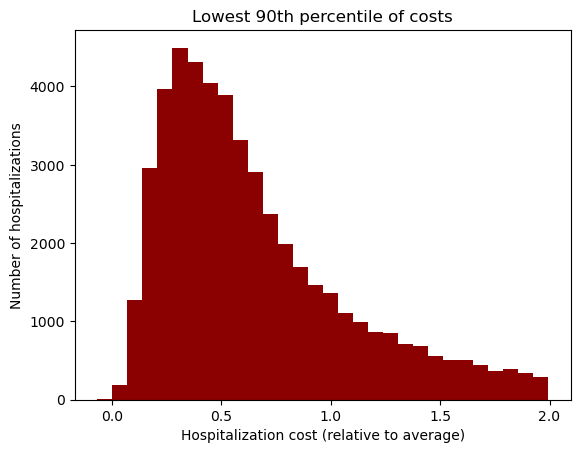

In [10]:
plot_cost_hist(q=0.9)